# tldr: Goose is probably a treeing walker coonhound

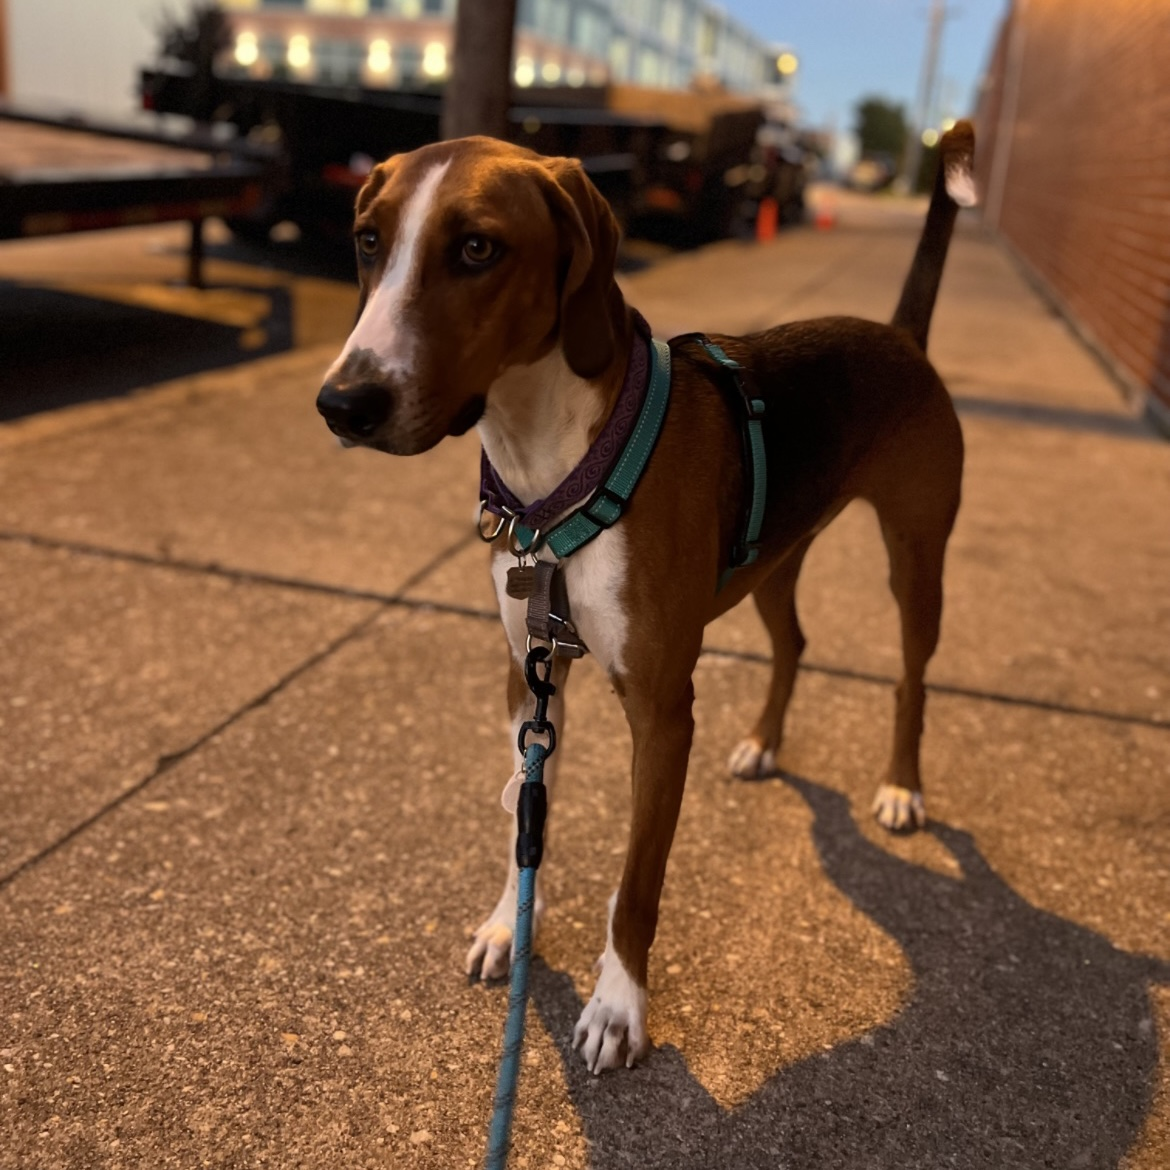

Last year I adopted a shelter dog whose breed was not known (and named him Goose). He clearly is some kind of hound, and a few google searches suggest he is some kind of foxhound. An interesting theme that began to emerge involved strangers that would stop (some literally pulling over their cars) when we were out on walks, comment on how handsome Goose is, and insist that he is either an American foxhound or a treeing walker coonhound and that they know because they've been around lots themselves. Not that rare I guess, considering that such hounds are often kept in large numbers for hunting.
<br />
<br />

These passerbys with very confident unsolicited opinions on what kind of dog Goose honestly just amused me for the most part, but in the pursuit of a project to brush up on my modeling skills, I thought about what things these confident people might be seeing that to them indicates so surely that Goose was of one breed or the other. So I decided to see if a computer could pick out distinct patterns between three visually similar subbreeds: American foxhouds, English foxhounds, and treeing walker coonhounds (hybrid American-English foxhounds). 
<br />
<br />

I used images scraped from DuckDuckGo to train a convolutional neural network to classify an image as one of three classes of foxhound. The resulting model classifies with ~70% accuracy on validation data, and classified 17 of 20 pictures of Goose as treeing walker coonhound.

# Methedology

**Image collection:**


*   Initially I figured I would gather images of foxhounds programatically from Gogle images. However, Google has recently restricted the images API to protect intellectual property, so I had to search for alternatives.
*   I tried Bing images but eventually settled on a package that scrapes images based on search terms from DuckDuckGo. A max of ~800 images were returned and saved by each search ("american foxhound", "english foxhound", and "treeing walker coonhound").
*   I took as given that labels were accurate; I know that some surely were not, but I am assuming that error rate was roughly equal across classes and therefore cancelled out in effect.
<br />
<br />

**Image cleaning:**


*   First I cropped all images to 176x176 squares. The model needs square inputs, and I ran into speed issues when trying any bigger.
*   Then, I visually looked over all images to weed out those that clearly didn't belong (think cartoon dogs, pictures of many dogs, etc.). Between these and duplicates that I removed, I was left with around half of my original images.
<br />
<br />

**Augmentation:**

*   First, pixel values were centered and normalized relative to training data means:




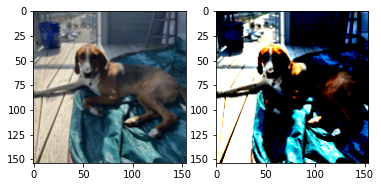

*   To effectively generate additional training data and enable my model to better generalize, I augmented data in a number of ways using Keras Image Data Generators. I randomly transformed data using flips, zooms, rotations, slides, etc. so that each time the computer sees any given image, it has undergone a number of transformations since the last time.
<br />
<br />

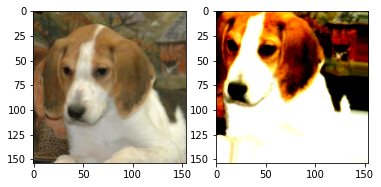

**Building a model:**


*   To brush up on the general mechanics of a convolutional neural network, see [this article](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) for a great explanation. I borrowed the visual below to give a rough idea of how such models work:

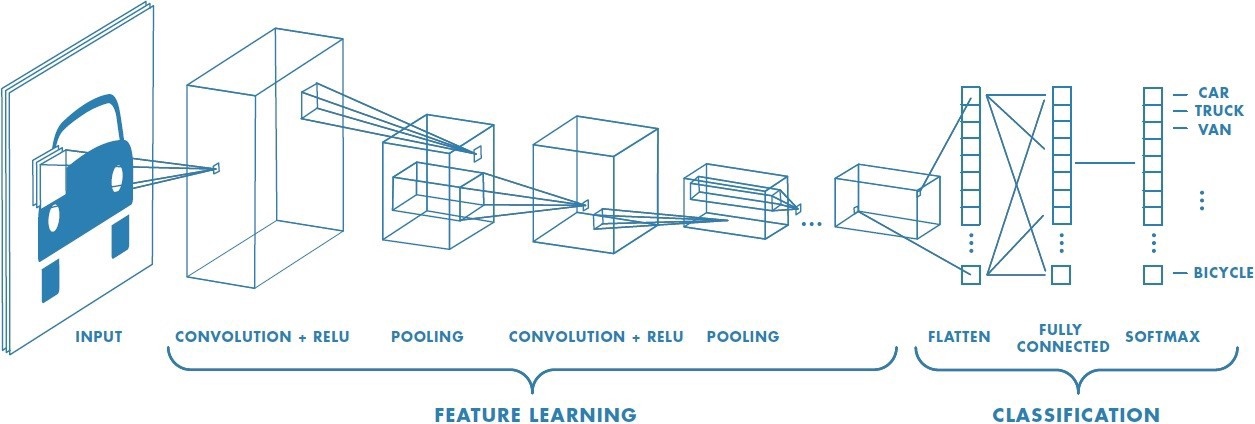


*   I first tried to train a model from scratch using only my ~1,000 original images. I did not get very here, barely crossing 50% accuracy on a three-way classification. I suspected this was due to the small sample size.
*   I next looked into transfer learning, which entails starting from weights pre-trained on large sets of labeled data; ultimately, borrowing pre-trained convolutional layers from the public VGG16 model dramatically increased the accuracy of my classification model.
*   Below you can see the layer specs of my final model - ultimately, most of the layers and parameters were taken directly from the VGG-16 model, and only the last few layers were customized accoording to my training data.



In [19]:
output.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 154, 154, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 154, 154, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 154, 154, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 77, 77, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 77, 77, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 77, 77, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 38, 38, 128)       0   

<br />
<br />

**Tuning hyperparamters:**


*   To somewhat optimize hyperparameters, I programatically ran through hundreds of combos of learning rates, dense layers, optimizers, etc etc until I landed on what appeared to be an optiumum (as far as I was willing to spend the time to find, at least).
*   It is worth noting that my small sample size resulted in significant noise each iteration that obscured the exact impact of changing any given hyperparameter.


# Results and ideas for the future

**Where I left things:**


*   After much tinkering, I settled with a model with 1 fully-connected layer with 64 neurons, 0.5 dropout after this layer, and the adam optimizer starting with a .0001 learning rate (decreased by a factor of 10 after 2 epochs without improvement to validation loss)
*   The model achieved ~70-75% accuracy on validation and holdout test data (hard to pinpoint an exact value due to small sample size and random element).
*   I fed in 20 pictures of Goose, and the model classified 17 of these as treeing walker coonhound. I can't say that this means much scientifically, but I am satisfied with the consistency and figure it might indicate my model to be somewhat precise in classification (meaning it generalizes well).

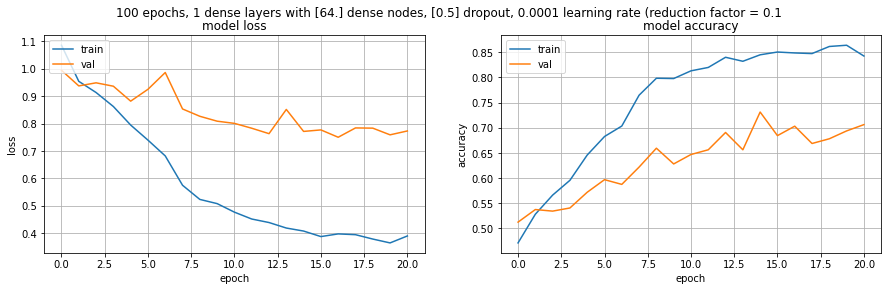

In [22]:
output = train_cnn(show_output = True, epochs = 100, dense = [[64, 0.5]], learning_rate = .0001, verbose = 0, early_stop_patience = 4, reduce_patience = 2)

In [10]:
labels = ['american', 'english', 'walker']
index = [labels[i] for i in output.predict(goose_generator, 20).argmax(axis = -1)]
[[x, index.count(x)] for x in set(index)]

[['walker', 16], ['english', 4]]


<br />
<br />

**How this idea could be improved upon with more time:**


*   If I had more labeled data at my disposal, I am confident I could build a much more robust model.
*   Learning rate schedules that entail more customization could hold promise.
*   Trying more combinations of VGG-16 layers and custom layers could highlight a better-performing combo.
*   I didn't spend much time experimenting with augmentation parameters, and just went with conservative values; more time here could yield improvement.
*   With more computing power I could use higher-quality images that preserve more detail.